##  Research on the optimization of multi-class land cover classification using deep learning with multispectral imagery

Yichuan Li, [Junchuan Yu*](https://github.com/JunchuanYu), Ming Wang, Minying Xie, Laidian Xi, Yunxuan Pang, and Changhong Hou


*corresponding author:yujunchuan@mail.cgs.gov.cn


Code:   [Github](https://github.com/JunchuanYu/OUNet_for_multi-class_land_cover_classification)




### Part2: Optimized solution

In [24]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time,glob
import os
from model import all_model
from utils import *

#### 1. Data optimization

In [3]:
## load multispectral data
hdf5_path = "./data/kaggle_14_8b_5c.hdf5"
fd = h5py.File(hdf5_path, 'r')
fd.keys()
images=fd['image']
labels=fd['label']
n_label=len(np.unique(labels)) #{0:'buiding',1:'Road', 2:'Tree',3: 'Crops',4:'Water'}
print(np.max(images),np.min(images),np.max(labels),np.min(labels))
images=np.array(images)
labels=np.array(labels)
print(images.shape,labels.shape)


9995 38 4 0
(14, 3840, 3840, 7) (14, 3840, 3840)


[99016105, 11047398, 17424954, 76998497, 1951446]


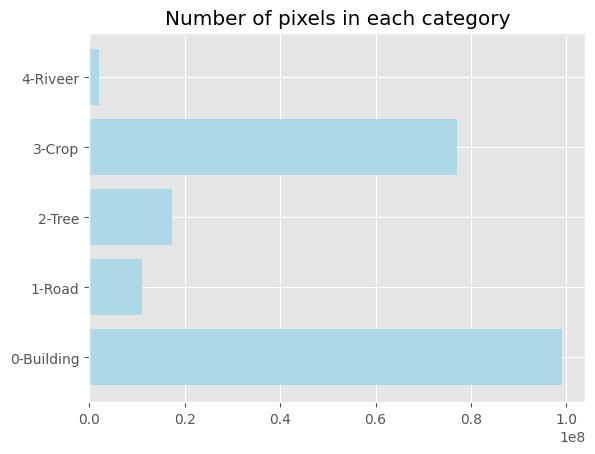

In [7]:
build_num = np.sum(labels ==0)
road_num = np.sum(labels == 1)
tree_num = np.sum(labels == 2)
crop_num = np.sum(labels == 3)
water_num = np.sum(labels == 4)
plt.style.use("ggplot")

classes = ('0-Building', '1-Road', '2-Tree', '3-Crop', '4-Riveer')
numbers = [build_num,road_num, tree_num,crop_num, water_num]
print(numbers)
plt.barh(classes, numbers,color='lightblue')
plt.title('Number of pixels in each category')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [9]:
## 将整幅影像及标签数据打印出来,为了提升原始影像的显示效果，对原有数据进行拉伸处理 
# Normalization
def stretch_n(band, lower_percent=5, higher_percent=95): #5和95表示分位数
    band=np.array(band,dtype=np.float32)
    c = np.percentile(band, lower_percent)*1.0
    d = np.percentile(band, higher_percent)*1.0       
    band[band<c] = c
    band[band>d] = d
    out =  (band - c)  / (d - c)  
    return out.astype(np.float32)

def adjust_contrast(data,n_band=3):    #通过循环对各个波段进行拉伸
    data=np.array(data,dtype=np.float32)
    for img in data:
        for k in range(n_band):
            img[:,:,k] = stretch_n(img[:,:,k])
    return data

newimg=adjust_contrast(images.copy(),images.shape[-1]) #该操作讲改变原始数据，因此用.copy，不对原始数据进行更改
print(np.max(images),np.max(newimg))

9995 1.0


In [13]:
# Show image
# show_5_images(newimg,labels)


In [14]:
## random crop
def data_crop_random(img_arr,crop_sz,n_patch):   
    data =[]
    k=0
    for j in np.arange(1000):
        image = random_crop(img_arr,crop_sz)
        if num_count(image[:,:,-1],1) +num_count(image[:,:,-1],4) >8000:
            data.append(image)
            k+=1
            if k==n_patch:
                break                 
    if k == 0:
        data  = np.expand_dims(image,axis=0) ##注意如果k=0，即没有符合条件的数据将最后一个image赋给data，避免data为空
    else:
        data  = np.array(data,dtype=np.float32)

    print(data.shape)
    return data.astype(np.float32)
def data_crop(imagearray,crop_sz,stride,random=None,n_patch=250):   
    data = []
    for i in range(imagearray.shape[0]):
        if random:
            image=data_crop_random(imagearray[i,:,:,:],crop_sz,n_patch)
        else:
            image =sequential_crop(imagearray[i,:,:,:],crop_sz,stride)
        if i == 0:
            data  = image ##注意当i=0的时候需要将image赋给data，否则data依然是空，不可以进行concatnate
        else:
            data  = np.concatenate((data, image), axis = 0) 
        print("patch processing....:"+str(i))
    data=np.array(data,dtype=np.float32)
    print("final processed:"+str(i)+"...No.:"+str(data.shape[0]))    
    return data

In [11]:
## 同样使用前面14幅影像进行切片，增加不平衡样本数据的采集
data_all = np.concatenate((newimg, np.expand_dims(labels,axis=-1)), axis = -1)
stride=256
cropsize=256
all_patches=data_crop(data_all,cropsize,stride,random=True)
print(data_all.shape,all_patches.shape)
i=0
all_patches=suffle_data(all_patches)

(1, 256, 256, 4)
patch processing....:0
(7, 256, 256, 4)
patch processing....:1
(247, 256, 256, 4)
patch processing....:2
(1, 256, 256, 4)
patch processing....:3
(250, 256, 256, 4)
patch processing....:4
(250, 256, 256, 4)
patch processing....:5
(64, 256, 256, 4)
patch processing....:6
(224, 256, 256, 4)
patch processing....:7
(150, 256, 256, 4)
patch processing....:8
(250, 256, 256, 4)
patch processing....:9
(74, 256, 256, 4)
patch processing....:10
(178, 256, 256, 4)
patch processing....:11
(18, 256, 256, 4)
patch processing....:12
(89, 256, 256, 4)
patch processing....:13
final processed:13...No.:1803
(14, 3840, 3840, 4) (1803, 256, 256, 4)


In [ ]:
# plot_func(all_patches[i:i+20,:,:,:3],all_patches[i:i+20:,:,:,-1])
# i+=500

In [16]:
# load the hdf5 croped by sequential mode
hdf5_path = "./data/patches_mul_8b_5c.hdf5"
fd = h5py.File(hdf5_path, 'r')
fd.keys()
images=np.array(fd['image'])
labels=np.array(fd['label'])

In [14]:
## combine two dataset
images=np.concatenate((images,all_patches[:,:,:,0:-1]),axis=0)
labels=np.concatenate((labels,all_patches[:,:,:,-1]),axis=0)
print(images.shape,labels.shape)

(4547, 256, 256, 3) (4547, 256, 256)


In [16]:
## save the final data
# hdf5_path = './data/patches2_rgb_4b_5c.hdf5' 
# f = h5py.File(hdf5_path, mode='w')
# f['image'] = images
# f['label'] = labels
# f.close()

In [17]:
del all_patches,data_all,newimg

#### 3. Model training

In [18]:
hdf5_path = './data/patches2_mul_8b_5c.hdf5' 
fd = h5py.File(hdf5_path, 'r')
fd.keys()
images=np.array(fd['image'])
labels=np.array(fd['label'])

In [19]:
## 对数据进行归一化处理，并将label转成one-hot标签形式
def post_normalize_image(images,labels,n_label=n_label):
    msk = label_hot(labels,n_label)
    img = images
    return img,msk
img,msk=post_normalize_image(images,labels,n_label)
# 将数据集按照7:3进行划分
xtrain,xtest,ytrain,ytest=train_test_split(img,msk,test_size=0.2,random_state=42)
del img,msk,images,labels #如果数据较大可以在此删除降低内存
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
i=0

(3608, 256, 256, 7) (903, 256, 256, 7) (3608, 256, 256, 5) (903, 256, 256, 5)


In [51]:
plot_func(xtrain[i:i+20,:,:,:3],np.argmax(ytrain,axis=-1)[i:i+20:,:,:])
i+=100

<Figure size 1800x360 with 10 Axes>

<Figure size 1800x360 with 10 Axes>

In [20]:
## Calculate the proportion of each category in the true label as the weight of the loss function. The larger the weight value, the greater the cost of model recognition errors, which helps to alleviate data imbalance to a certain extent.
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(labels)  
class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=labels.reshape(-1))
# class_weight=np.array([0.35,4.48,2.07,0.68,28.55])
# print(class_weight)

[ 0.35  4.48  2.07  0.68 28.55]


In [29]:
# define the wce lossfunction
from keras import backend as K
import tensorflow as tf
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

In [27]:
## 设定必要的参数
loss=weighted_categorical_crossentropy(class_weight)
optimizer=Adam()
loss_weights=''
metrics=['accuracy']
batch_size=10
epoch= 40
input_height=xtrain.shape[1]
input_width=xtrain.shape[2]
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,n_label,nchannel)
modelname='optimization'

In [28]:
## load OUNet
model=ATM.OUNet()
# model.summary()

384


In [21]:
## training
begin_time = time.time()          
out_dir = "./checkpoint/"+modelname+'/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir) 

model_checkpoint = ModelCheckpoint(filepath=out_dir+modelname+".hdf5",monitor="val_loss",save_best_only=True,mode='auto')

## save history
csvlogger =CSVLogger(filename=out_dir+modelname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/40
363/363 [==============================] - 619s 2s/step - loss: 1.6130 - accuracy: 0.3414 - val_loss: 2.7607 - val_accuracy: 0.2265
Epoch 2/40
363/363 [==============================] - 546s 2s/step - loss: 1.1976 - accuracy: 0.4340 - val_loss: 1.2325 - val_accuracy: 0.4583
Epoch 3/40
363/363 [==============================] - 546s 2s/step - loss: 1.1025 - accuracy: 0.4758 - val_loss: 3.7192 - val_accuracy: 0.3219
Epoch 4/40
363/363 [==============================] - 545s 2s/step - loss: 1.2474 - accuracy: 0.4341 - val_loss: 1.0075 - val_accuracy: 0.5466
Epoch 5/40
363/363 [==============================] - 544s 1s/step - loss: 0.9964 - accuracy: 0.5055 - val_loss: 0.9588 - val_accuracy: 0.5855
Epoch 6/40
363/363 [==============================] - 543s 1s/step - loss: 0.9365 - accuracy: 0.5350 - val_loss: 0.7650 - val_accuracy: 0.5750
Epoch 7/40
363/363 [==============================] - 544s 1s/step - loss: 0.8234 - accuracy: 0.5584 - val_loss: 0.7328 - val_accuracy: 0.6061

In [31]:
## load the best checkpoint
h5=glob.glob("./checkpoint/"+modelname+"/*.hdf5")
model_list=np.sort(h5)
model=load_model(model_list[-1],custom_objects={'loss':weighted_categorical_crossentropy}) #loss作为自定义层需要指出
print(model_list[-1])

./checkpoint/optimization\convattunet_multi-44e-val_loss0.281526.hdf5


In [32]:
i=100
pred=model.predict(xtest,batch_size=64)
pred=np.argmax(pred,axis=-1)
gt=np.argmax(ytest,axis=-1)


15/15 [==============================] - 15s 620ms/step


In [33]:
##  Accuracy Evaluation
df = call_matric(pred,gt, [0,1,2,3,4, 'all'])
print(df)

     precision    recall  F1-score       iou        oa      miou
0     0.965631  0.772736  0.858481  0.752052  0.845818  0.709005
1     0.568562  0.946664  0.710438  0.550914  0.845818  0.709005
2     0.645074  0.909333  0.754741  0.606091  0.845818  0.709005
3     0.909801  0.918300  0.914031  0.841673  0.845818  0.709005
4     0.797067  0.995637  0.885355  0.794293  0.845818  0.709005
all   0.777227  0.908534  0.824609  0.709005  0.845818  0.709005


#### 5. Prediction results visulization

In [34]:
data=np.load(r'./data/patch_test.npy')
print(data.shape,np.max(data))

(8, 256, 256, 8) 4.0


In [37]:
## patch prediction visulization
pred=model.predict(data[:,:,:,:-1],batch_size=64)
pred=np.argmax(pred,axis=-1)
gt=np.argmax(data[:,:,:,-1],axis=-1)

1/1 [==============================] - 1s 797ms/step


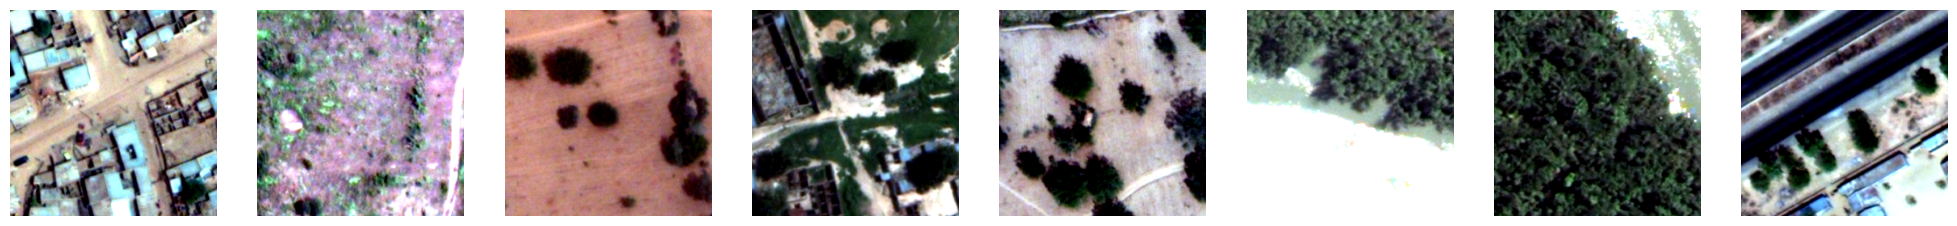

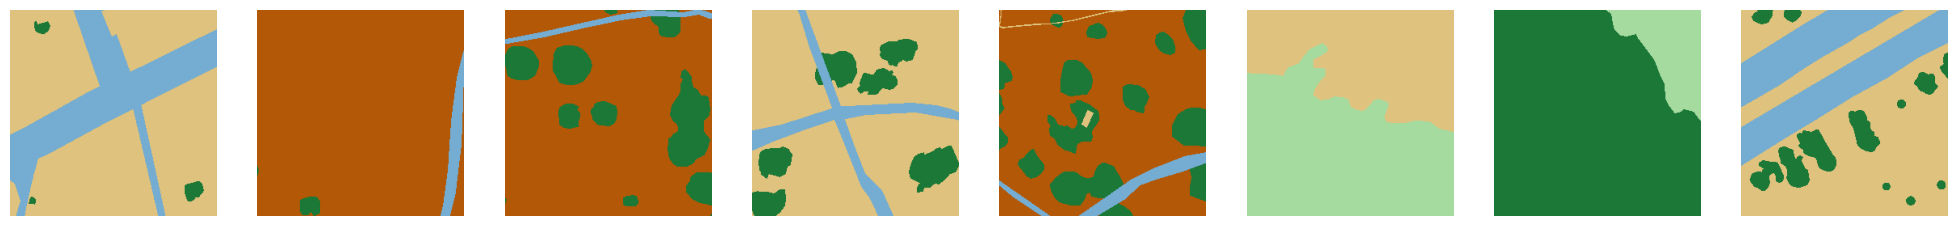

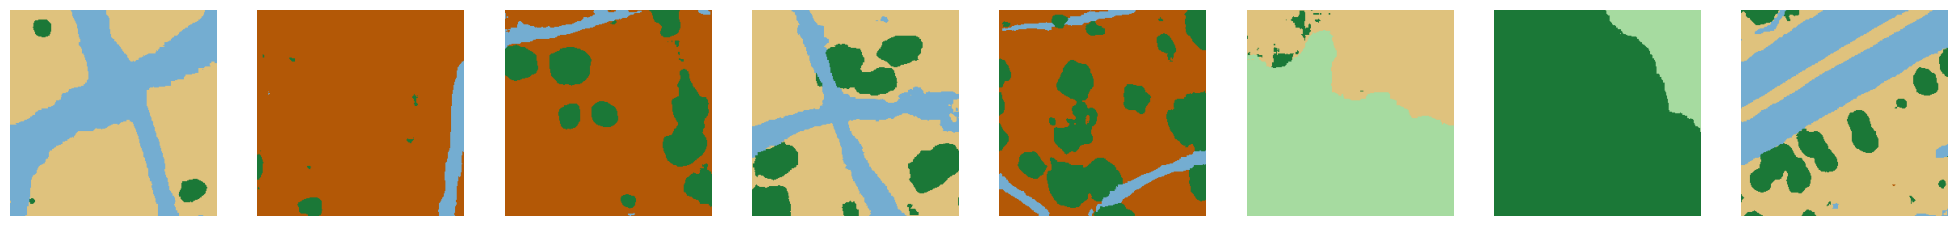

In [38]:
palette = np.array([ [223,194,125],   [116,173,209],   [27,120,55], [179,88,6], [166,219,160]]) 
predc=palette[pred]
gt=np.array(data[:,:,:,-1],dtype=np.uint8)
gtc=palette[gt]

new_val_plot(data,gtc,predc)

In [47]:
## image prediction visulisation
## load imgage
test_data  = h5py.File('./data/kaggle_test1_8b_5c.hdf5', 'r')
testimg = np.array(test_data['image'])
testlabel=np.array(test_data['label'])
print(testimg.shape,testlabel.shape)

(1, 3840, 3840, 7) (1, 3840, 3840)


In [49]:
image=adjust_contrast(testimg,n_band=testimg.shape[-1])
np.max(image),np.max(testimg)

(1.0, 9995)

In [50]:
predicts=[]
for i in range(image.shape[0]):
    h_pred = center_predict(image[0],model,32,n_label)
    h_pred_mask=np.argmax(h_pred, axis = -1)
    palette = np.array([ [223,194,125],   [116,173,209],   [27,120,55], [179,88,6], [166,219,160]]) 
    predc=palette[h_pred_mask]
    predicts.append(predc)  
result=np.array(predicts)

31/31 [==============================] - 11s 305ms/step
pred_time: 15.861923933029175


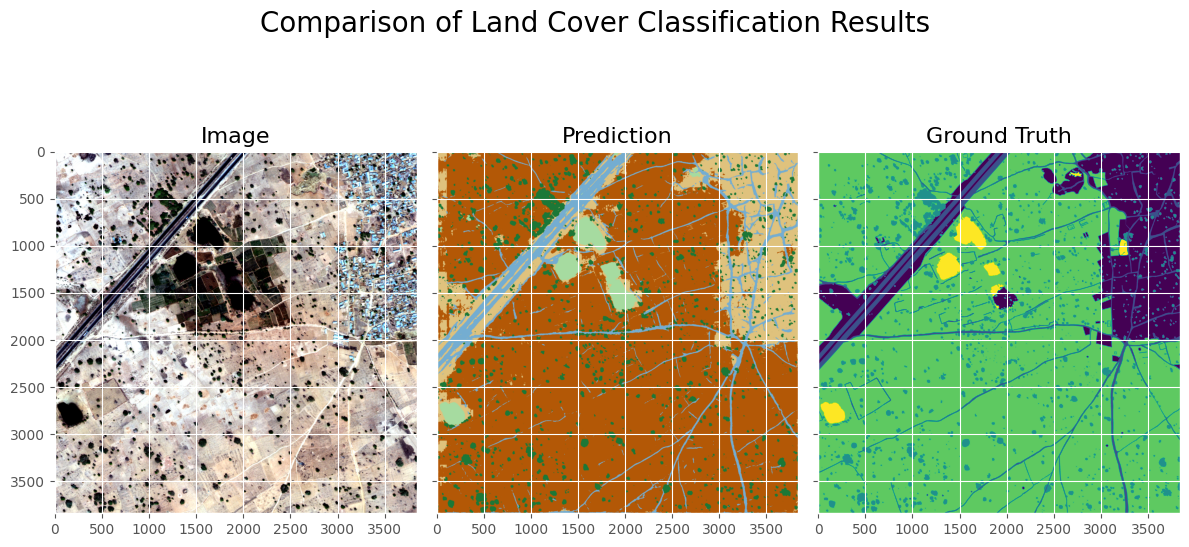

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(12,10))
axs[0].imshow(image[0,:,:,:3])
axs[0].set_title('Image', fontsize=16)
axs[1].imshow(result[0])
axs[1].set_title('Prediction', fontsize=16)
axs[2].imshow(testlabel[0])
axs[2].set_title('Ground Truth', fontsize=16)

for ax in fig.get_axes():
    ax.label_outer()
    ax.ticklabel_format(style ='plain') 
fig.tight_layout()
fig.suptitle('Comparison of Land Cover Classification Results', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.3, wspace=None, hspace=0.2)


##### The study demonstrates some basic optimization strategies for multispectral classification using deep learning. The current classification performance can be further improved by increasing the model size, augmenting data with a small proportion, and other methods.